## Tutorial development 1 : create a simple component

In this document, we develop a now EESREP component. This component will make the cogeneration of electricty and heat from a fuel input.

This tutorial is adapted to user who want to develop customized components and not simply use the built-in components. A full understanding of the user tutorials is necessary before starting development.

###   Imports

In [7]:
import math

import pandas as pd
import matplotlib.pyplot as plt

from eesrep import Eesrep
from eesrep.components.generic_component import GenericComponent
from eesrep.components.sink_source import FatalSink
from eesrep.solver_interface.generic_interface import GenericInterface
from eesrep.eesrep_enum import TimeSerieType

### Create the component definition

Every EESREP component must inherit from the GenerticComponent class, and define the three following functions:

-   \_\_init\_\_ : Instanciates the object, and stores its parameters and time series.
-   io_from_parameters : Lists the component Input/Outputs for a given set of parameters.
-   build_model : creates the model equations at a given rolling horizon

For the tutorial, the Cogeneration class is defined in several jupyter cell.

The first function defined here is **\_\_init\_\_**.

The function creates the object taking both the parameters and the time series for the whole simulation. The parameters have to be set as class attributes, and the time series to be stored in a dictionnary attribute called time_series. An exemple is provided in the following cell.

This component will have two inputs and one output. The model will be :

    output(t) = (intput1(t) + input2(t)) * efficiency
    intput2(t) = input1(t) * ratio

The component will have a cost based on the output value.

It is important to note here that the name of the component must be requested in by the \_\_init\_\_ function, and has to be stored in self.name.

In [8]:
class Cogeneration(GenericComponent):
    """EESREP cogeneration model :
        The cogeneration output equals input1 * efficiency + input2 * ratio * efficiency"""

    def __init__(self, 
                    name:str,
                    efficiency:float,
                    p_max:float,
                    ratio:float,
                    opex:float,
                    some_ts:pd.DataFrame = pd.DataFrame()):
        
        self.name = name
        self.efficiency = efficiency
        self.p_max = p_max
        self.ratio = ratio
        self.opex = opex

        #   Necessary object, instanciate empty if not used
        self.time_series = {
            # "some_time_serie":{
            #     "type":TimeSerieType.INTENSIVE,
            #     "value":some_ts
            # } 
        }

For this component, all variables will be intensive. As they don't need to be continuous from a rolling horizon to the next (as a storage value would), the continuity parameter is set to False.

The parameters given in the dictionnary have no impact on the inputs/outputs presence in the component model.

In [9]:

class Cogeneration(Cogeneration):
    """EESREP cogeneration model :
        The cogeneration output equals input1 * efficiency + input2 * ratio * efficiency"""

    def io_from_parameters(self) -> dict:
        """Lists the component Input/Output.
        """
        return {
                    "power_in1":{
                                    "type": TimeSerieType.INTENSIVE,
                                    "continuity":False
                                },
                    "power_in2":{
                                    "type": TimeSerieType.INTENSIVE,
                                    "continuity":False
                                },
                    "power_out":{
                                    "type": TimeSerieType.INTENSIVE,
                                    "continuity":False
                                }
                }


The building of the model is done in three steps:

-   Variables creation : The variables are requested to the model inteface. You can either request one or several variables at a time, and request either continuous or discrete variables (float or int).

-   Constraints declaration : At each time step of the horizon, the variables are linked to each others, or to float values, using equality/lower_than/greater_than constraints. The create_***_constraints functions expect, as first argument, a table listing all variables in the equation with their sign which will be summed as the left hand side of the equation, and a value as second argument, which will be the right hand side of the equation.

-   Objective definition : The objective is set using the declared variables. A sum_variables function in the model_interface is available for summing more than 2 objects.

In [10]:

class Cogeneration(Cogeneration):
    """EESREP cogeneration model :
        output = (input1 + input2) * efficiency 
        input2 = ratio*input1
    """

    def build_model(self,
        component_name:str,
        time_steps:list,
        time_series:pd.DataFrame,
        history:pd.DataFrame,
        model_interface:GenericInterface):
        """Builds the model at the current horizon.

        Parameters
        ----------
        component_name : str
            Component name to index the MILP variables
        time_steps : list
            List of the time steps length 
        time_series : pd.DataFrame
            Dataframe containing the time series values at the current horizon time steps.
        history : pd.DataFrame
            Dataframe with the variables of previous iterations if "continuity" is at true.
        model_interface : GenericInterface
            Solver interface used to provide the variables

        """
        variables = {}

        variables["power_in1"] = model_interface.get_new_continuous_variable_list(component_name+"_power_in1_", len(time_steps), 0, self.p_max)
        variables["power_in2"] = model_interface.get_new_continuous_variable_list(component_name+"_power_in2_", len(time_steps), 0, self.p_max)
        variables["power_out"] = model_interface.get_new_continuous_variable_list(component_name+"_power_out_", len(time_steps), 0, (1+self.ratio)*self.p_max)

        for i in range(len(time_steps)):
            model_interface.add_equality(model_interface.sum_variables([
                                                                variables["power_out"][i],
                                                                -variables["power_in1"][i]*self.efficiency, 
                                                                -variables["power_in2"][i]*self.efficiency
                                                            ]), 
                                                            0)
                                                            
            model_interface.add_equality(model_interface.sum_variables([
                                                                variables["power_in1"][i]*self.ratio, 
                                                                -variables["power_in2"][i]
                                                            ]), 
                                                            0)

        objective = model_interface.sum_variables([val * self.opex for val in variables["power_out"]])
        
        return variables, objective


###   Create model

Create the Eesrep object and declaration of the Cogeneration component type.

In [11]:
model = Eesrep(solver="CBC")

Create the bus and link the components together.

Similarly to the add_link function, the plug_to_bus function takes few arguments:
-   name of the component to plug to the bus;
-   input/output of the component to plug to the bus;
-   name of the bus;
-   if we are plugging an input (boolean);
-   multiplication factor;
-   offset.

In [12]:
model.add_component(Cogeneration("cogeneration",
                                    efficiency=.9,
                                    p_max=1000.,
                                    ratio=2.,
                                    opex=1.
                                ))

model.add_component(FatalSink("load",pd.DataFrame({"time": list(range(101)), "value": [i for i in range(101)]})))

model.add_link("cogeneration", "power_out", "load", "power_in", 1., 0.)

###   Set up simulation

In this tutorial, we ask EESREP to split the 1000 time steps resolution in 10 * 100 time steps. Each resolution will start 100 steps after the previous, making no overlap between each resolution.

Each resolution is faster, but more are required. A good balance needs to be found between the time range parameters to get a proper result at a good computation time.

In [13]:
model.define_time_range(1., 1, 100, 1)

###   Solve and get results

In [14]:
model.solve()

results = model.get_results(as_dataframe=True)

Running first time step


The following plot displays that the component's behavior indeed matches the provided equations

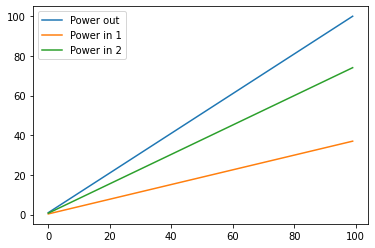

In [15]:
plt.plot(results["cogeneration_power_out"], label = "Power out")
plt.plot(results["cogeneration_power_in1"], label = "Power in 1")
plt.plot(results["cogeneration_power_in2"], label = "Power in 2")
plt.legend()
plt.show()